In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

<AxesSubplot:>

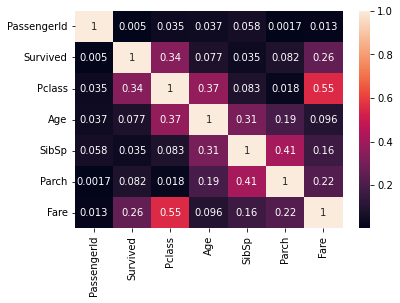

In [3]:
sns.heatmap(np.abs(train.corr()), annot=True)

In [4]:
mean_age = np.mean(train["Age"])

def preprocess_data(df):
    df["special_title"] = df["Name"].apply(lambda x: 0 if re.search("(\w+\. )", x)[0] in ["Mr. ", "Mrs. ", "Miss. ", "Ms. "] else 1)
    ohe = OneHotEncoder(sparse=False)
    df["embarked_S"], df["embarked_C"], df["embarked_Q"] = ohe.fit_transform(df["Embarked"].values.reshape(-1, 1))[:, 0:3].T
    df["sex_encoded"] = (df["Sex"].values == "female").astype(int)
    cabin_class_encoder = {char: idx+1 for idx, char in enumerate('ABCDEGFT')}
    df["cabin_encoded"] = np.nan_to_num(df.Cabin.apply(lambda x: cabin_class_encoder[x[0]] if not isinstance(x, float) else x))
    df["Age"] = df["Age"].apply(lambda x: mean_age if np.isnan(x) else x)
    preprocessed_df = df.select_dtypes(include="number").drop(columns="PassengerId")
    return preprocessed_df

In [5]:
preprocessed_train = preprocess_data(train)
preprocessed_test = preprocess_data(test)

In [6]:
lgbm = LGBMClassifier()
lgbm.fit(X=preprocessed_train.drop(columns=["Survived"]), y=preprocessed_train["Survived"])

LGBMClassifier()

In [7]:
test["Survived"] = lgbm.predict(preprocessed_test)
submission = test[["PassengerId", "Survived"]]

In [8]:
submission.to_csv("submission.csv", index=False)

In [9]:
pd.read_csv("submission.csv")

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
